In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from My_Pred_Modelling import classification_modelling, modelling, models_graph
from My_Pred_Modelling import param_to_model_transform

In [3]:
def apply_pca(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(pca.components_.T,          # transpose the matrix of loadings
                            columns=component_names,    # so the columns are the principal components
                            index=X.columns)            # and the rows are the original features
    return pca, X_pca, loadings

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, discrete_features=False, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [4]:
df = pd.read_pickle('L_Prep_State')
df.STATE = df.STATE.replace({'norm': 0, 'AC': 1, 'SCC': 2})
df.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,STATE
GTEX-111CU,6.282829,0.187227,16.459309,1.390586,9.284774,1.817905,8.861321,9.356633,7.162157,0.405928,...,6.51922,5.774152,8.752136,10.276568,0.395912,9.567469,13.064981,10.710016,9.178765,0
GTEX-111FC,6.459492,0.386816,16.357314,1.462766,8.363233,2.132,9.006019,8.859413,6.86954,0.912104,...,6.3021,5.82059,8.343859,10.116765,0.997971,9.816011,12.760873,10.042366,9.167625,0
GTEX-111VG,7.143432,-0.003366,17.293667,3.257567,9.789358,1.98931,9.090267,9.029279,6.511335,2.000838,...,5.736464,5.852467,8.692399,9.894538,1.543979,9.80994,13.636654,10.698651,8.804904,0
GTEX-111YS,6.464637,0.061339,15.854521,1.953561,8.419853,1.315828,8.923156,9.24981,9.213866,0.004093,...,6.219143,5.812366,8.67694,10.376354,0.589715,10.132188,12.351264,10.884633,9.129941,0
GTEX-1122O,6.826894,-0.094578,16.039283,2.107355,8.505655,2.619394,9.076225,9.249061,8.817053,-0.682806,...,6.624728,5.650416,8.57541,10.407757,1.191774,9.888598,12.661172,10.8646,8.97088,0


In [5]:
X = df.drop('STATE', axis=1)
y = df.STATE

In [6]:
X.shape

(1706, 17593)

We can try to detect the number of components needed to capture 95% of the variance.

In [7]:
pca = PCA()
pca.fit(X)
explained_variance_ratio = pca.explained_variance_ratio_
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)
# You can choose a threshold for the cumulative explained variance
threshold = 0.95  # to capture 95% of the variance
n_components_needed = np.argmax(cumulative_variance >= threshold) + 1
print("Number of components needed to capture", threshold * 100, "% of the variance:", n_components_needed)

Number of components needed to capture 95.0 % of the variance: 769


We received a huge amount of components, and it makes sense to look at the MI scores of the components when we take n_components=n_components_needed.

In [10]:
#print(df[features].corrwith(df.SalePrice))
pca, X_pca, loadings = apply_pca(X, n_components_needed)
mi_scores = make_mi_scores(X_pca, y)
mi_scores.head()

PC1     0.870991
PC2     0.715127
PC11    0.226195
PC20    0.214873
PC9     0.168167
Name: MI Scores, dtype: float64

And we see the big difference between values of PC1, PC2 and other components.
Perhaps it is enough to take only two components to receive a good result.

In [9]:
pca2, X_pca_2, loadings2 = apply_pca(X, 2)
mi_scores2 = make_mi_scores(X_pca_2, y)
print(mi_scores2)

PC1    0.870991
PC2    0.715127
Name: MI Scores, dtype: float64


In [12]:
loadings2.sort_values(by=['PC1', 'PC2'], ascending=[False, True])

,PC1,PC2
KRT6A,0.046878,-0.056316
KRT16,0.042509,-0.040806
KRT6B,0.041090,-0.057819
DSG3,0.040664,-0.072637
CALML3,0.040506,-0.064933
...,...,...
SFTPA2,-0.041403,0.000793
AGER,-0.042312,-0.018856
SFTPA1,-0.042967,0.000686
CLDN18,-0.047759,-0.017590


In [20]:
# It can be useful for further investigation.
features_PCA2_100 = loadings2.sort_values(by=['PC1', 'PC2'], ascending=[False, True]).iloc[:100, :].index
with open('features_PCA2_100.pkl', 'wb') as file:
    pickle.dump(features_PCA2_100, file)
features_PCA2_100

Index(['KRT6A', 'KRT16', 'KRT6B', 'DSG3', 'CALML3', 'KRT6C', 'AKR1B10',
       'PRAME', 'SERPINB5', 'KRT14', 'GJB6', 'ZBTB9', 'SPRR1B', 'PITX1',
       'FOXE1', 'COL11A1', 'CA9', 'A2ML1', 'COL7A1', 'ABCA12', 'KRT5',
       'SERPINB13', 'GPR87', 'GRHL3', 'SPRR3', 'GPX2', 'B4GALNT4', 'RHCG',
       'DSC3', 'GJB2', 'SPRR1A', 'LY6D', 'SPRR2A', 'MMP11', 'S100A2', 'PNCK',
       'MAGEA4', 'TMPRSS4', 'KRT17', 'MMP12', 'PPP2R2C', 'FAM83B', 'MMP1',
       'HMGA2', 'CDC45', 'NXPH4', 'PTHLH', 'CST1', 'TMPRSS11D', 'DUSP9',
       'BIRC5', 'MAGEA6', 'MYBL2', 'DLX6', 'COL17A1', 'TFAP2A', 'SLC2A1',
       'SPRR2D', 'TROAP', 'ZIC2', 'HOXC13', 'FAM83A', 'PADI3', 'MAGEA9B',
       'FAT2', 'UBE2C', 'AMIGO3', 'BARX1', 'KIF4A', 'C12orf56', 'KIF18B',
       'GABRA3', 'TTK', 'NUF2', 'FAM83C', 'DLGAP5', 'MELK', 'CDC20', 'MAGEA3',
       'S100A7', 'HJURP', 'SBSN', 'UGT1A6', 'AURKB', 'CENPA', 'LYPD3', 'TPX2',
       'TNS4', 'BUB1B', 'HOXD11', 'LGALS7', 'KRT15', 'PKP1', 'DEPDC1',
       'SERPINB4', 'KIF2C', 'DLX

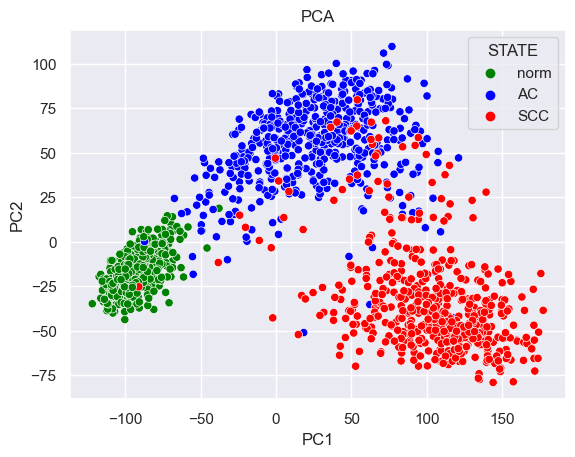

In [18]:
pca2 = PCA(n_components=2)
pca_2 = pca2.fit_transform(X)

pca2_df = pd.DataFrame(data=pca_2, columns=['PC1', 'PC2'], index=df.index)
pca2_df = pd.concat([pca2_df, y], axis=1)
pca2_df.STATE = pca2_df.STATE.replace({0: 'norm', 1: 'AC', 2: 'SCC'})

sns.scatterplot(data=pca2_df, x='PC1', y='PC2', hue='STATE', palette=['green', 'blue', 'red' ])
plt.title('PCA')
#plt.savefig('PCA_2.svg')
plt.show()

And indeed we got a pretty good separation of the states.

### Selection of optimal hyperparameters for models

In [14]:
X_train, X_test, y_train, y_test = train_test_split(pca2_df.drop('STATE', axis=1), y, test_size=0.2)

In [15]:
# Define the hyperparameters to search
param_Ada = {'n_estimators': list(range(40, 90, 5)),
             'learning_rate': np.arange(0.04, 0.2, 0.02).round(2).tolist(),
             'base_estimator': [None, DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]}
param_XG = {'n_estimators': list(range(20, 60, 5)),
            'learning_rate': np.arange(0.01, 0.2, 0.02).round(2).tolist(),
            'max_depth': list(range(3, 15))}
param_RF = {'n_estimators': list(range(10, 60, 5)),
            'max_depth': [None, 1, 2, 3, 4],
            'min_samples_split': list(range(5, 20, 5)),
            'min_samples_leaf': list(range(1, 10))}
param_GB = {'n_estimators': list(range(50, 251, 50)),
            'learning_rate': np.arange(0.01, 0.1, 0.02).round(2).tolist(),
            'max_depth': list(range(1, 5))}
param_KN = {'n_neighbors': list(range(3, 15, 2)),
            'leaf_size': list(range(1, 5)),
            'weights': ['uniform', 'distance'],
            'p': [1, 2]}  # 1 for Manhattan distance, 2 for Euclidean distance

In [16]:
model = [RandomForestClassifier(), XGBClassifier(), KNeighborsClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()]
params = [param_RF, param_XG, param_KN, param_Ada, param_GB]

In [19]:
# classification_modelling is my function for selecting the best hyperparameters
res_pca2 = classification_modelling(pca2_df.drop('STATE', axis=1), y, params=params)
# we save the best model hyperparameters for our case
pickle.dump(res_pca2, open('pca2_opt_params.pkl', 'wb'))
# param_to_model_transform is my function for transformation the dictionaries with best params to model input
optimal_models_pca2 = param_to_model_transform(res_pca2)

Model:  RandomForestClassifier
Best Hyperparameters:  {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 35}
Accuracy on Test Data: 0.95906
Model:  XGBClassifier
Best Hyperparameters:  {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 30}
Accuracy on Test Data: 0.96784
Model:  KNeighborsClassifier
Best Hyperparameters:  {'leaf_size': 1, 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
Accuracy on Test Data: 0.96199
Model:  AdaBoostClassifier
Best Hyperparameters:  {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.06, 'n_estimators': 55}
Accuracy on Test Data: 0.95614
Model:  GradientBoostingClassifier
Best Hyperparameters:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 200}
Accuracy on Test Data: 0.95906


In [27]:
# modelling is my function to wrap the results of modelling with the best params into DataFrame
model_PCA_2 = modelling(pca2_df.drop('STATE', axis=1), y, optimal_models_pca2)
model_PCA_2

,mean_score,std_score
KNeighborsClassifier,96.42,0.88
RandomForestClassifier,96.19,1.34
XGBClassifier,96.19,1.20
GradientBoostingClassifier,96.07,1.07
AdaBoostClassifier,95.96,1.37


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


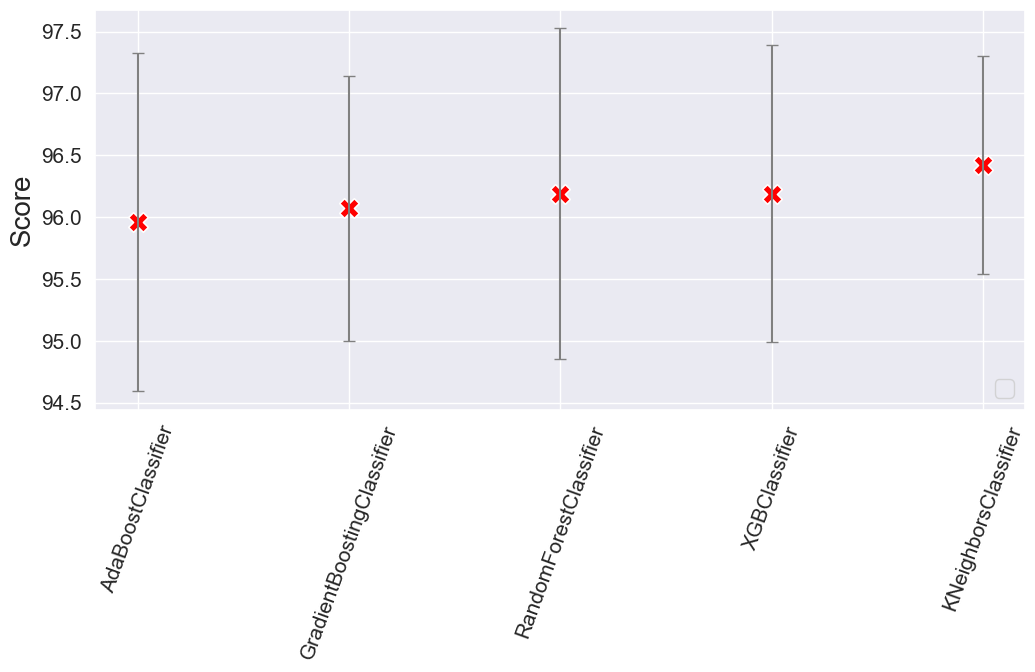

In [28]:
models_graph(model_PCA_2, 'Models_PCA2')

So we have almost the same values for all models.
Let's try the all 769 components.

In [23]:
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC760,PC761,PC762,PC763,PC764,PC765,PC766,PC767,PC768,PC769
0,-80.113615,-6.014284,35.000181,-25.685495,-18.673485,5.804199,-21.634036,-0.252276,-15.949131,2.307007,...,2.328814,-0.896111,1.179546,1.774975,-0.355046,0.421559,2.007620,-0.528511,2.763498,0.696081
1,-101.697426,-28.903993,-6.594762,26.981748,-3.997071,3.677100,32.539104,0.983780,8.422315,-3.170833,...,0.956543,-1.818636,0.408856,-1.032548,0.751881,0.093330,0.395608,0.555610,-0.009177,-2.353537
2,-99.689990,-35.781649,-44.233612,16.941334,-11.574584,-7.506469,44.085540,-2.231055,-6.234191,-12.190741,...,0.046947,1.157225,-0.746251,0.251704,1.366029,-1.218104,1.575602,-0.328754,-0.564801,0.427320
3,-107.212722,-27.506178,21.559789,14.802261,-7.164157,7.545785,-10.521711,-8.150297,-4.942822,4.978325,...,1.993798,0.861876,-0.331671,-0.722785,-1.566801,0.392164,0.155391,1.188282,-0.967019,-0.412284
4,-101.994198,-13.891664,34.602139,2.009577,8.540664,2.702289,-30.601768,8.658541,-3.960712,17.449216,...,-1.393075,0.553603,-0.230173,-1.044395,-0.127895,-1.079608,0.621819,-0.005557,-1.446470,0.277415


In [37]:
# Define the hyperparameters to search
param_Ada_ = {'n_estimators': [50, 100, 200],
             'learning_rate': [0.01, 0.05],
             'base_estimator': [None, DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]}
param_XG_ = {'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05],
            'max_depth': [3, 5, 10]}
param_RF_ = {'n_estimators': [50, 100, 200],
            'max_depth': [None, 1, 2, 3, 4],
            'min_samples_split': list(range(5, 20, 5)),
            'min_samples_leaf': [3, 5, 10]}
param_GB_ = {'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05],
            'max_depth': list(range(1, 5))}
param_KN_ = {'n_neighbors': list(range(3, 15, 2)),
            'leaf_size': list(range(1, 5)),
            'weights': ['uniform', 'distance'],
            'p': [1, 2]}  # 1 for Manhattan distance, 2 for Euclidean distance
params_ = [param_RF_, param_XG_, param_KN_, param_Ada_, param_GB_]

In [38]:
res_pca769 = classification_modelling(X_pca, y, params=params_)
optimal_models_pca769 = param_to_model_transform(res_pca769)
model_PCA_769 = modelling(X_pca, y, m=optimal_models_pca769)
pickle.dump(res_pca769, open('pca769_opt_params.pkl', 'wb'))

Model:  RandomForestClassifier
Best Hyperparameters:  {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy on Test Data: 0.97368
Model:  XGBClassifier
Best Hyperparameters:  {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}
Accuracy on Test Data: 0.96784
Model:  KNeighborsClassifier
Best Hyperparameters:  {'leaf_size': 1, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Accuracy on Test Data: 0.96784
Model:  AdaBoostClassifier
Best Hyperparameters:  {'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.01, 'n_estimators': 100}
Accuracy on Test Data: 0.97368
Model:  GradientBoostingClassifier
Best Hyperparameters:  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50}
Accuracy on Test Data: 0.97076


In [43]:
X_pca_4 = X_pca[mi_scores[mi_scores > 0.2].index.tolist()]
res_pca4 = classification_modelling(X_pca_4, y, params=params_)
optimal_models_pca4 = param_to_model_transform(res_pca4)
model_PCA_4 = modelling(X_pca_4, y, m=optimal_models_pca4)
pickle.dump(res_pca4, open('pca4_opt_params.pkl', 'wb'))

Model:  RandomForestClassifier
Best Hyperparameters:  {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy on Test Data: 0.94444
Model:  XGBClassifier
Best Hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy on Test Data: 0.95614
Model:  KNeighborsClassifier
Best Hyperparameters:  {'leaf_size': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Accuracy on Test Data: 0.95906
Model:  AdaBoostClassifier
Best Hyperparameters:  {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.01, 'n_estimators': 50}
Accuracy on Test Data: 0.94737
Model:  GradientBoostingClassifier
Best Hyperparameters:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}
Accuracy on Test Data: 0.95614


In [44]:
X_pca_8 = X_pca[mi_scores[mi_scores > 0.15].index.tolist()]
res_pca8 = classification_modelling(X_pca_8, y, params=params_)
optimal_models_pca8 = param_to_model_transform(res_pca8)
model_PCA_8 = modelling(X_pca_8, y, m=optimal_models_pca8)
pickle.dump(res_pca8, open('pca8_opt_params.pkl', 'wb'))

Model:  RandomForestClassifier
Best Hyperparameters:  {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy on Test Data: 0.97076
Model:  XGBClassifier
Best Hyperparameters:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50}
Accuracy on Test Data: 0.96784
Model:  KNeighborsClassifier
Best Hyperparameters:  {'leaf_size': 1, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
Accuracy on Test Data: 0.96491
Model:  AdaBoostClassifier
Best Hyperparameters:  {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.01, 'n_estimators': 50}
Accuracy on Test Data: 0.96491
Model:  GradientBoostingClassifier
Best Hyperparameters:  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
Accuracy on Test Data: 0.96784


In [47]:
X_pca_39 = X_pca[mi_scores[mi_scores > 0.13].index.tolist()]
res_pca39 = classification_modelling(X_pca_39, y, params=params_)
optimal_models_pca39 = param_to_model_transform(res_pca39)
model_PCA_39 = modelling(X_pca_39, y, m=optimal_models_pca39)
pickle.dump(res_pca39, open('pca39_opt_params.pkl', 'wb'))

Model:  RandomForestClassifier
Best Hyperparameters:  {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 100}
Accuracy on Test Data: 0.95614
Model:  XGBClassifier
Best Hyperparameters:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Accuracy on Test Data: 0.95614
Model:  KNeighborsClassifier
Best Hyperparameters:  {'leaf_size': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Accuracy on Test Data: 0.95322
Model:  AdaBoostClassifier
Best Hyperparameters:  {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.01, 'n_estimators': 100}
Accuracy on Test Data: 0.95029
Model:  GradientBoostingClassifier
Best Hyperparameters:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}
Accuracy on Test Data: 0.95029


In [48]:
numbers_PCA = ['PCA 2', 'PCA 4', 'PCA 8', 'PCA 39', 'PCA 769']
cols = [m.__class__.__name__ for m in model]
scores_PCAs = pd.concat([model_PCA_2.mean_score, model_PCA_4.mean_score, model_PCA_8.mean_score, model_PCA_39.mean_score, model_PCA_769.mean_score], axis=1).T
scores_PCAs.index = numbers_PCA
scores_PCAs

,KNeighborsClassifier,RandomForestClassifier,XGBClassifier,GradientBoostingClassifier,AdaBoostClassifier
PCA 2,96.42,96.19,96.19,96.07,95.96
PCA 4,96.19,96.31,96.25,96.25,95.55
PCA 8,96.37,96.37,95.78,96.13,95.55
PCA 39,96.37,96.19,96.60,96.01,95.72
PCA 769,96.31,96.31,96.43,96.19,95.66


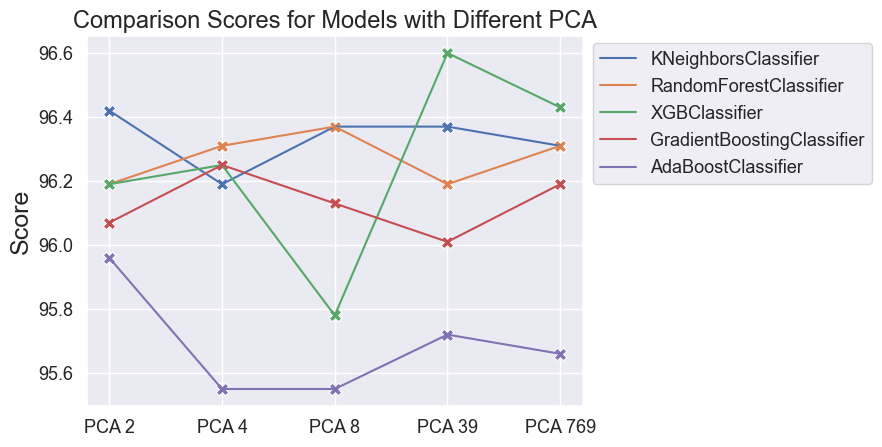

In [54]:
for col in scores_PCAs.columns:
    g = sns.lineplot(data=scores_PCAs, x=scores_PCAs.index, y=col, label=col);
    g = sns.scatterplot(data=scores_PCAs, x=scores_PCAs.index, s=80, marker='X', y=col);
g.set_ylabel('Score', fontsize=18)
g.set_title('Comparison Scores for Models with Different PCA', fontsize=17)
g.tick_params(labelsize=13)
plt.legend(loc=(1.02, 0.6), fontsize=13)
plt.savefig('Comparison_Model_Scores_PCA_.svg', bbox_inches='tight', pad_inches=0.1)

We reselected the optimal parameters for PCA8 and didn't receive more better scores finally.

Now we save the PCA model to further usage it with new data.

In [106]:
pca = PCA(n_components=2)
pca.fit(X)
pickle.dump(pca, open('pca_2_transform.pkl', 'wb'))

In [107]:
# For further using this transformation
# with open('pca_2_transform.pkl', 'rb') as pickle_file:
#     pca = pickle.load(pickle_file)
# scaled_data = pca.transform(X)